# Explore the CpG islands

---



## <span class="label label-success"> Analysis </span>


---

## <span class="label label-warning">NOTE</span>

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.style.use('ggplot')

import os
import subprocess
import time

import re

In [2]:
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/explore_data'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)
os.environ['TMPDIR']='/nagyvinyok/adat84/sotejedlik/ribli/tmp'

In [3]:
#sql exetcuter func
def run_sqlilte3(command,db,output=''):
    start=time.time()
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    try:
        print subprocess.check_output('/usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output,
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output
    
    subprocess.call(['rm','tempf.sql'])
    print 'It took',int(time.time()-start),'s'

In [28]:
#sql exetcuter func
def run_sqlilte3_slurm(command,db,output=''):
    with open('tempf.sql','w') as tempf:
        tempf.write(command)
        
    if output != '':
        output=' > '+output
    
    with open('tempf_sql.sh','w') as tempf:
        tempf.write('#!/bin/sh\n /usr/bin/sqlite3 '+ db + ' < tempf.sql '+ output)
        
    try:
        print subprocess.check_output('sbatch -C jimgray83 tempf_sql.sh',
                                      shell=True, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError, e:
        print e.output

---

### Calculate medians for probes on CpG islands


In [55]:
run_sqlilte3('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH med_table AS (
    SELECT probe AS probe,MEDIAN(beta) AS medb ,STDEV(beta) AS stdb
    FROM normal_h_meth
    GROUP BY probe)

SELECT m.medb
FROM ncbi_450_annot AS n
INNER JOIN med_table AS m ON m.probe=n.IlmnID
WHERE n.Relation_to_UCSC_CpG_Island='Island';

''',db='../db/meth_db',output='island_median_beta.csv')


It took 17 s


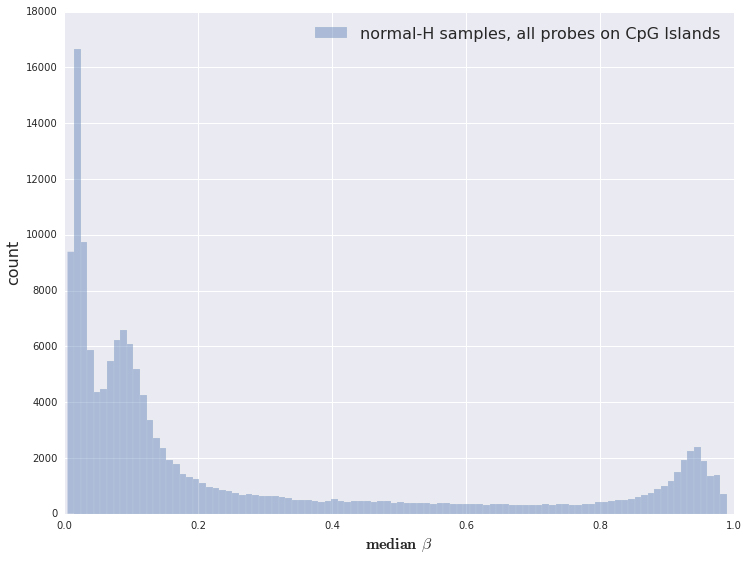

In [64]:
test_hist=pd.read_csv('island_median_beta.csv',header=None,sep='\t',
                     names=['medb'])

fig,ax=plt.subplots()
fig.set_size_inches(12,9)

sns.distplot(test_hist['medb'],hist=True,kde=False,rug=False,bins=100,
                  label='normal-H samples, all probes on CpG Islands')

ax.set_xlim(0,1)
ax.set_xlabel(r'median $\beta$',fontsize=16)
ax.set_ylabel('count',fontsize=16)
dump=ax.legend(loc='best',fontsize=16)

In [65]:
print '# methylated probes on CpG islands',np.sum(test_hist.medb > 0.8)
print '# unmethylated probes on CpG islands',np.sum(test_hist.medb < 0.3)

# methylated probes on CpG islands 21023
# unmethylated probes on CpG islands 108584


### Group by CpG islands

In [34]:
run_sqlilte3_slurm('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

SELECT n.UCSC_CpG_Islands_Name as island, MEDIAN(beta) AS medb ,STDEV(beta) AS stdb
FROM normal_h_meth as m
INNER JOIN ncbi_450_annot AS n ON m.probe=n.IlmnID
WHERE n.Relation_to_UCSC_CpG_Island='Island'
GROUP BY n.UCSC_CpG_Islands_Name;

''',db='../db/meth_db',output='island_grouped_beta.csv')

sbatch: error: UnkillableStepTimeout specified more than once, latest value used
Submitted batch job 341252



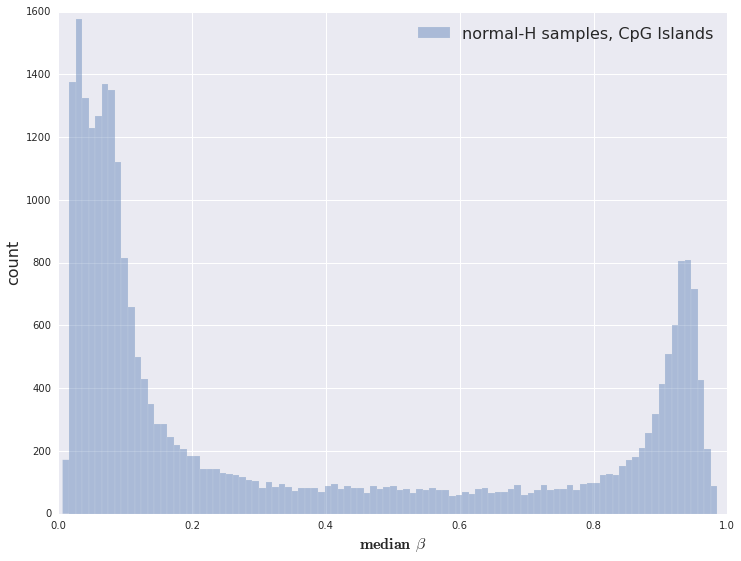

In [63]:
test_hist=pd.read_csv('island_grouped_beta.csv',header=None,sep='\t',
                     names=['island','medb','stdb'])

fig,ax=plt.subplots()
fig.set_size_inches(12,9)

sns.distplot(test_hist['medb'],hist=True,kde=False,rug=False,bins=100,
                  label='normal-H samples, CpG Islands')

ax.set_xlim(0,1)
ax.set_xlabel(r'median $\beta$',fontsize=16)
ax.set_ylabel('count',fontsize=16)
dump=ax.legend(loc='best',fontsize=16)

In [51]:
print '# methylated CpG islands',np.sum(test_hist.medb > 0.8)
print '# unmethylated CpG islands',np.sum(test_hist.medb < 0.3)

# methylated CpG islands 6326
# unmethylated CpG islands 16287


## Differential methylation

In [74]:
#create the heatmap
run_sqlilte3_slurm('''
.separator "\t"

WITH dmed1 AS (
    SELECT dmb.probe,dmb.medb 
    FROM disease_median_beta AS dmb
    INNER JOIN ncbi_450_annot AS n ON dmb.probe=n.IlmnID
    WHERE n.Relation_to_UCSC_CpG_Island='Island' AND
    dmb.disease='cancer'),
    
dmed2 AS (
    SELECT dmb.probe,dmb.medb 
    FROM disease_median_beta AS dmb
    INNER JOIN ncbi_450_annot AS n ON dmb.probe=n.IlmnID
    WHERE n.Relation_to_UCSC_CpG_Island='Island' AND
    dmb.disease='normal-C')

SELECT ROUND((dmed1.medb)*100)*0.01 AS cancer_bin,
       ROUND((dmed2.medb)*100)*0.01 AS normal_bin, COUNT(*)
FROM dmed1
INNER JOIN dmed2 ON dmed1.probe=dmed2.probe
GROUP BY ROUND((dmed1.medb)*100)*0.01,
       ROUND((dmed2.medb)*100)*0.01;

''',db='../db/meth_db',output='cpg_island_norm_canc_med_heatmap.csv')

sbatch: error: UnkillableStepTimeout specified more than once, latest value used
Submitted batch job 341254



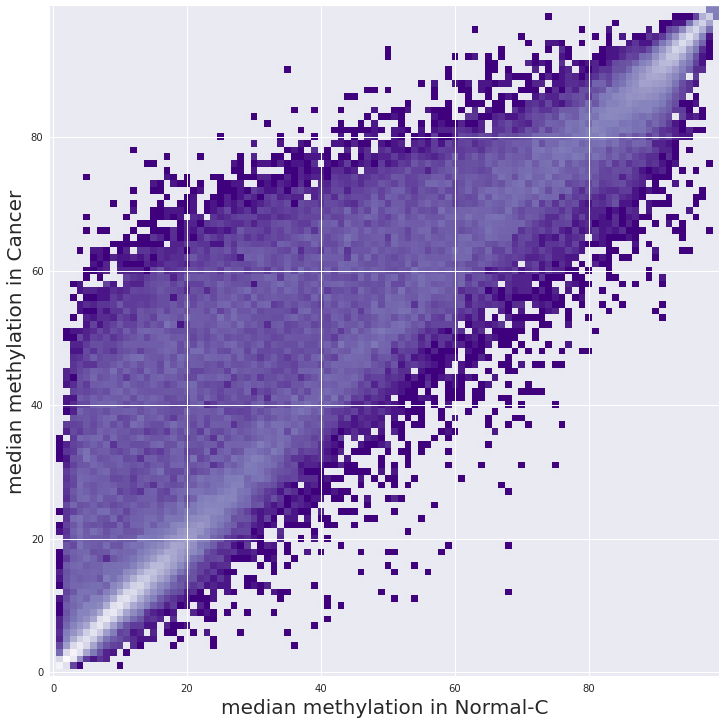

In [75]:
# load the heatmap
my_heatmap=np.zeros([100,100])
f=open('cpg_island_norm_canc_med_heatmap.csv')
for line in f:
    line_list=line.split('\t')
    canc_bin=int(np.round(100*float(line_list[0])))
    norm_bin=int(np.round(100*float(line_list[1])))
    count=int(line_list[2])
    my_heatmap[canc_bin,norm_bin]+=count
f.close()

#plot it
from matplotlib.colors import LogNorm
fig,ax=plt.subplots()
fig.set_size_inches(12,12)
ax.imshow(my_heatmap,interpolation='none',origin='lower', 
          norm=LogNorm(),cmap=plt.cm.Purples_r)
ax.set_xlabel('median methylation in Normal-C',fontsize=20)
dump=ax.set_ylabel('median methylation in Cancer',fontsize=20)

### Grouped by islands

In [70]:
#create the heatmap
run_sqlilte3_slurm('''
.separator "\t"
.load /home/ribli/tools/sqlite_math_ext/libsqlitefunctions

WITH dmed1 AS (
    SELECT n.UCSC_CpG_Islands_Name AS island, MEDIAN(dmb.medb) AS medb
    FROM disease_median_beta AS dmb
    INNER JOIN ncbi_450_annot AS n ON dmb.probe=n.IlmnID
    WHERE n.Relation_to_UCSC_CpG_Island='Island' AND
    dmb.disease='cancer'
    GROUP BY n.UCSC_CpG_Islands_Name),
    
dmed2 AS (
    SELECT n.UCSC_CpG_Islands_Name AS island,MEDIAN(dmb.medb) AS medb
    FROM disease_median_beta AS dmb
    INNER JOIN ncbi_450_annot AS n ON dmb.probe=n.IlmnID
    WHERE n.Relation_to_UCSC_CpG_Island='Island' AND
    dmb.disease='normal-C'
    GROUP BY n.UCSC_CpG_Islands_Name)

SELECT ROUND((dmed1.medb)*100)*0.01 AS cancer_bin,
       ROUND((dmed2.medb)*100)*0.01 AS normal_bin, COUNT(*)
FROM dmed1
INNER JOIN dmed2 ON dmed1.island=dmed2.island
GROUP BY ROUND((dmed1.medb)*100)*0.01,
       ROUND((dmed2.medb)*100)*0.01;

''',db='../db/meth_db',output='cpg_island_grouped_norm_canc_med_heatmap.csv')

sbatch: error: UnkillableStepTimeout specified more than once, latest value used
Submitted batch job 341253



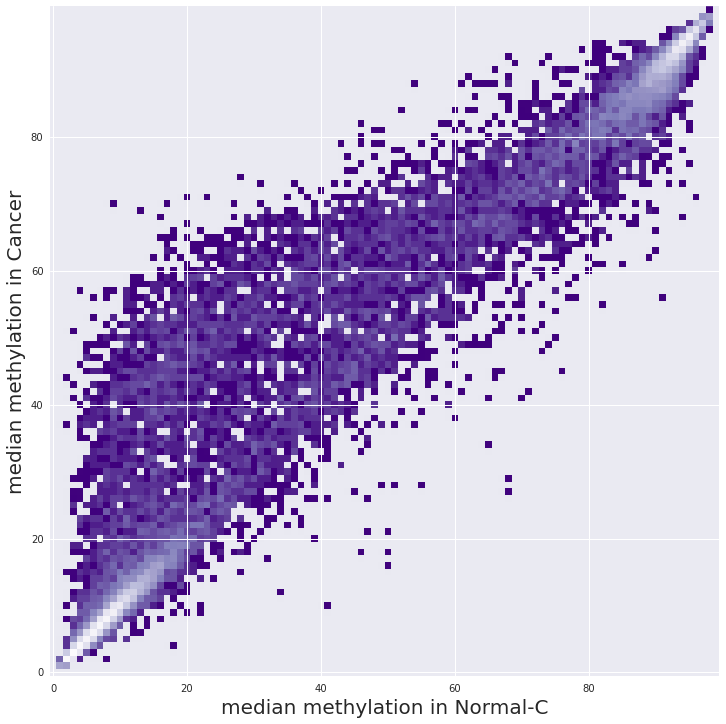

In [72]:
# load the heatmap
my_heatmap=np.zeros([100,100])
f=open('cpg_island_grouped_norm_canc_med_heatmap.csv')
for line in f:
    line_list=line.split('\t')
    canc_bin=int(np.round(100*float(line_list[0])))
    norm_bin=int(np.round(100*float(line_list[1])))
    count=int(line_list[2])
    my_heatmap[canc_bin,norm_bin]+=count
f.close()

#plot it
from matplotlib.colors import LogNorm
fig,ax=plt.subplots()
fig.set_size_inches(12,12)
ax.imshow(my_heatmap,interpolation='none',origin='lower', 
          norm=LogNorm(),cmap=plt.cm.Purples_r)
ax.set_xlabel('median methylation in Normal-C',fontsize=20)
dump=ax.set_ylabel('median methylation in Cancer',fontsize=20)